## Using library

In [3]:
using Printf
using DelimitedFiles

## Configuration data struct

In [4]:
@enum InterpolationType UPWIND LINEAR QUICK

struct CaseConfig
    # 1 dimensional configuration 
    MIN_X::Float64
    MAX_X::Float64
    NUM_X_CELLS::Int64
    NUM_GHOST_CELLS::Int64
    NUM_RK_STEPS::Int64
    NUM_TIME_STEPS::Int64
    TIME_STEPS_SIZE::Float64
    ADVECTION_VEL::Float64
    VAR_INTERPOLATION_TYPE::InterpolationType
end

function GET_NUM_CELLS(config::CaseConfig)
    return config.NUM_X_CELLS + config.NUM_GHOST_CELLS*2
end

function SHOW_CONFIG(config::CaseConfig)
    println("MIN_X: ",config.MIN_X, ", MAX_X: ",config.MAX_X,
            ",\nNUM_X_CELLS: ", config.NUM_X_CELLS, ", NUM_GHOST_CELLS: ", config.NUM_GHOST_CELLS,
            ",\nNUM_RK_STEPS: ", config.NUM_RK_STEPS, ", NUM_TIME_STEPS: ", config.NUM_TIME_STEPS,
            ",\nTIME_STEPS_SIZE: ", config.TIME_STEPS_SIZE, ", ADVECTION_VEL: ", config.ADVECTION_VEL)
end

SHOW_CONFIG (generic function with 1 method)

## Cell data struct

In [5]:
mutable struct Cell
    # 1 dimensional cell data
    CELL_CENTER::Float64
    CELL_WEST::Float64
    CELL_EAST::Float64
    CELL_SIZE::Float64
    CELL_VAR::Array{Float64,1}
    WEST_FACE_VAR::Float64
    EAST_FACE_VAR::Float64
    WEST_FACE_UNITNORM::Float64
    EAST_FACE_UNITNORM::Float64
    TOTAL_FLUX::Array{Float64,1}
    
    function Cell(config::CaseConfig, idx::Int64)
        this = new()
        dx = (config.MAX_X - config.MIN_X) / config.NUM_X_CELLS
        this.CELL_SIZE = dx
        this.CELL_VAR = zeros(config.NUM_RK_STEPS+1)
        this.TOTAL_FLUX = zeros(config.NUM_RK_STEPS)
        this.CELL_CENTER = config.MIN_X + dx*(idx - 0.5 - config.NUM_GHOST_CELLS)
        this.CELL_WEST = this.CELL_CENTER - 0.5*this.CELL_SIZE
        this.CELL_EAST = this.CELL_CENTER + 0.5*this.CELL_SIZE
        this.WEST_FACE_UNITNORM = -1.0
        this.EAST_FACE_UNITNORM = 1.0
    
        return this
    end
    
end

## Initializer struct

In [6]:
struct SolutionInitializer
    REC_WAVE_SART::Float64
    REC_WAVE_END::Float64
end

function INITIALIZE(initializer::SolutionInitializer, case::CaseConfig, cells::Array{Cell,1})
    
    for rkSteps = 1:case.NUM_RK_STEPS + 1
        for each_cell in cells
            if ( each_cell.CELL_CENTER >= initializer.REC_WAVE_SART &&
                 each_cell.CELL_CENTER <= initializer.REC_WAVE_END )
                 each_cell.CELL_VAR[rkSteps] = 1.0
            else
                 each_cell.CELL_VAR[rkSteps] = 0.0
            end
        end
    end
    
end

INITIALIZE (generic function with 1 method)

## Writer struct

In [7]:
struct SolutionWriter
    SolutionWriter() = new()
end

function WRITEFILE(writer::SolutionWriter, case::CaseConfig, cells::Array{Cell,1}, time::Float64)

    if time == 0.0
        for delete_filename in filter(x -> occursin(r".dat$", x), readdir())
            rm(delete_filename)
        end
    end
        
    
    filename =  string("solution", (@sprintf("%5.3f", time)), ".dat")
    
    open(filename, "w") do file
        
        for each_cell in cells
            temp1 = each_cell.CELL_CENTER
            temp2 = each_cell.CELL_VAR[case.NUM_RK_STEPS + 1]
            
            if temp1 >= case.MIN_X && temp1 <= case.MAX_X
                write(file, "$temp1, $temp2 \n")
            end
        end
        
    end
end

WRITEFILE (generic function with 1 method)

## Plotter struct

In [9]:
using Plots

struct SolutionPlotter
    
end

function PLOTSOLUTION(plotter::SolutionPlotter, case::CaseConfig, cells::Array{Cell,1}, time::Float64)

    title =  string("Solution at ", (@sprintf("%5.3f", time)), " sec")
    filename =  string("solution", (@sprintf("%5.3f", time)), ".dat")
    
    data = readdlm(filename, ',')

    pos_data = data[:,1]
    var_data = data[:,2]

    plot(pos_data, var_data, linewidth=2, xlabel="x axis (m)",
                                          ylabel="y value", 
                                          title=title)
    
    plot!(pos_data, var_data, seriestype=:scatter, markershape = :xcross, markersize = 2,
                                                   markercolor = :black)


end


function ANIMATESOLUTION(plotter::SolutionPlotter, case::CaseConfig)

    anim = Animation()

    for tSteps = 1 : case.NUM_TIME_STEPS
        
        time = case.TIME_STEPS_SIZE*tSteps
        
        title =  string("Solution at ", (@sprintf("%5.3f", time)), " sec")
    
        filename =  string("solution", (@sprintf("%5.3f", time)), ".dat")

        data = readdlm(filename, ',')

        pos_data = data[:,1]
        var_data = data[:,2]

        plot(pos_data, var_data, linewidth=2, xlabel="x axis (m)",
                                              ylabel="y value", 
                                              title=title)

        plot!(pos_data, var_data, seriestype=:scatter, markershape = :xcross, markersize = 2,
                                                       markercolor = :black)

        frame(anim)
        
    end
    
    gif(anim, "solution_fps30.gif", fps = 30)

end

ANIMATESOLUTION (generic function with 1 method)

---

## Interpolation function

In [10]:
# Calculate VAR on two sides of each cell
function InterpolationFun(case::CaseConfig, cells::Array{Cell,1}, rkSteps)
    # ===================================================================     
    # UPWING INTERPOLATION
    # ===================================================================     
    if case.VAR_INTERPOLATION_TYPE == UPWIND
        for idx = case.NUM_GHOST_CELLS+1 : case.NUM_GHOST_CELLS + case.NUM_X_CELLS
            P_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
            E_CELL_VAR = cells[idx+1].CELL_VAR[rkSteps]
            W_CELL_VAR = cells[idx-1].CELL_VAR[rkSteps]
            
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].WEST_FACE_UNITNORM)
            
            cells[idx].WEST_FACE_VAR = ( 0.5*advec_sign*(W_CELL_VAR + P_CELL_VAR) -
                                         0.5*abs(advec_sign)*(W_CELL_VAR - P_CELL_VAR) )*advec_sign
            
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].EAST_FACE_UNITNORM)
            
            cells[idx].EAST_FACE_VAR =( 0.5*advec_sign*(E_CELL_VAR + P_CELL_VAR) -
                                        0.5*abs(advec_sign)*(E_CELL_VAR - P_CELL_VAR) )*advec_sign
            
        end
    # ===================================================================     
    # LINEAR INTERPOLATION
    # ===================================================================    
    elseif case.VAR_INTERPOLATION_TYPE == LINEAR
        for idx = case.NUM_GHOST_CELLS + 1 : case.NUM_GHOST_CELLS + case.NUM_X_CELLS
            P_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
            E_CELL_VAR = cells[idx+1].CELL_VAR[rkSteps]
            W_CELL_VAR = cells[idx-1].CELL_VAR[rkSteps]
                
            lamda = ( cells[idx].CELL_WEST - cells[idx-1].CELL_CENTER ) / ( cells[idx].CELL_CENTER - cells[idx-1].CELL_CENTER) 
            cells[idx].WEST_FACE_VAR = P_CELL_VAR*lamda + W_CELL_VAR*(1-lamda)
                
            lamda = ( cells[idx].CELL_EAST - cells[idx].CELL_CENTER ) / ( cells[idx+1].CELL_CENTER - cells[idx].CELL_CENTER) 
            cells[idx].EAST_FACE_VAR = E_CELL_VAR*lamda + P_CELL_VAR*(1-lamda)
                
        end
    # ===================================================================     
    # QUICK INTERPOLATION
    # ===================================================================    
    elseif case.VAR_INTERPOLATION_TYPE == QUICK
        for idx = case.NUM_GHOST_CELLS + 1 : case.NUM_GHOST_CELLS + case.NUM_X_CELLS
                    
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].WEST_FACE_UNITNORM)
            step = convert(Int64, -advec_sign*cells[idx].WEST_FACE_UNITNORM)
                    
            if advec_sign < 0       
                U_CELL_VAR = cells[idx+ step].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step*2].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx + step].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step*2].CELL_CENTER
                D_CELL_CENTER = cells[idx].CELL_CENTER        
            else
                U_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx - step].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step].CELL_CENTER
                D_CELL_CENTER = cells[idx - step].CELL_CENTER           
            end
                        
                    
            g1 = ( (cells[idx].CELL_WEST - U_CELL_CENTER)*(cells[idx].CELL_WEST - UU_CELL_CENTER) /
                   (D_CELL_CENTER - U_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) ) 
                    
            g2 = ( (cells[idx].CELL_WEST - U_CELL_CENTER)*(D_CELL_CENTER - cells[idx].CELL_WEST) /
                   (U_CELL_CENTER - UU_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) )  
  
            cells[idx].WEST_FACE_VAR = U_CELL_VAR + g1*(D_CELL_VAR-U_CELL_VAR) + g2*(U_CELL_VAR-UU_CELL_VAR)
                    
                        
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].EAST_FACE_UNITNORM)
            step = convert(Int64, -advec_sign*cells[idx].EAST_FACE_UNITNORM)
                    
            if advec_sign > 0       
                U_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx - step].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step].CELL_CENTER
                D_CELL_CENTER = cells[idx - step].CELL_CENTER          
            else
                U_CELL_VAR = cells[idx + step].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step*2].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx + step].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step*2].CELL_CENTER
                D_CELL_CENTER = cells[idx].CELL_CENTER       
            end
                    
            g1 = ( (cells[idx].CELL_EAST - U_CELL_CENTER)*(cells[idx].CELL_EAST - UU_CELL_CENTER) / 
                   (D_CELL_CENTER - U_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) ) 
                    
            g2 = ( (cells[idx].CELL_EAST - U_CELL_CENTER)*(D_CELL_CENTER - cells[idx].CELL_EAST) /
                   (U_CELL_CENTER - UU_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) )  
                    
            cells[idx].EAST_FACE_VAR = U_CELL_VAR + g1*(D_CELL_VAR-U_CELL_VAR) + g2*(U_CELL_VAR-UU_CELL_VAR)
             
        end
    else     
        error("interpolation type is not defined yet!")    
    end
end

InterpolationFun (generic function with 1 method)

##  time marching function

---

In [11]:
# http://mathworld.wolfram.com/Runge-KuttaMethod.html
function timemarchingFun(case::CaseConfig, cells::Array{Cell,1})
    
    if case.NUM_RK_STEPS == 1
        coeff = [1]
    elseif case.NUM_RK_STEPS == 2
        coeff = [0.5 1]
    elseif case.NUM_RK_STEPS == 4
        coeff = [0.5 0.5 1]
    end
    
    for each_cell in cells
        each_cell.CELL_VAR[1] = each_cell.CELL_VAR[case.NUM_RK_STEPS+1]
    end
    # ===================================================================     
    # One Step RK (forward euler)
    # ===================================================================
    
    for rkSteps = 1 : case.NUM_RK_STEPS
        
        # Update ghost cells for periodic boundary conditions        
        for ghostcell = 1 : case.NUM_GHOST_CELLS
            # First two ghost cells   
            cells[ghostcell].CELL_VAR[rkSteps] = 
                cells[case.NUM_X_CELLS + ghostcell].CELL_VAR[rkSteps]
            
            # Last two ghost cells   
            cells[case.NUM_X_CELLS + case.NUM_GHOST_CELLS + ghostcell].CELL_VAR[rkSteps] = 
                cells[case.NUM_GHOST_CELLS + ghostcell].CELL_VAR[rkSteps]
        end
        
        # Calculate VAR on two sides of each cell
        InterpolationFun(case, cells, rkSteps)

        # Calculate total flux of a cell
        for idx = case.NUM_GHOST_CELLS+1 : case.NUM_GHOST_CELLS+case.NUM_X_CELLS
            
            west_advec_sign = sign(case.ADVECTION_VEL*cells[idx].WEST_FACE_UNITNORM)
            east_advec_sign = sign(case.ADVECTION_VEL*cells[idx].EAST_FACE_UNITNORM)
            
            cells[idx].TOTAL_FLUX[rkSteps] = - case.ADVECTION_VEL*( west_advec_sign*cells[idx].WEST_FACE_VAR +
                                                                    east_advec_sign*cells[idx].EAST_FACE_VAR )
        end

        # Update cell variable from governing eq
        if rkSteps != 4
            for idx = case.NUM_GHOST_CELLS+1 : case.NUM_GHOST_CELLS+case.NUM_X_CELLS
                cells[idx].CELL_VAR[rkSteps+1] = cells[idx].CELL_VAR[1] +
                                                 coeff[rkSteps]*case.TIME_STEPS_SIZE*cells[idx].TOTAL_FLUX[rkSteps]/cells[idx].CELL_SIZE      
            end
        else
            for idx = case.NUM_GHOST_CELLS+1 : case.NUM_GHOST_CELLS+case.NUM_X_CELLS
                cells[idx].CELL_VAR[rkSteps+1] = cells[idx].CELL_VAR[1] +
                                                 case.TIME_STEPS_SIZE*cells[idx].TOTAL_FLUX[1]/cells[idx].CELL_SIZE/6 +
                                                 case.TIME_STEPS_SIZE*cells[idx].TOTAL_FLUX[2]/cells[idx].CELL_SIZE/3 +
                                                 case.TIME_STEPS_SIZE*cells[idx].TOTAL_FLUX[3]/cells[idx].CELL_SIZE/3 +
                                                 case.TIME_STEPS_SIZE*cells[idx].TOTAL_FLUX[4]/cells[idx].CELL_SIZE/6
            end
        end
    end
    

    
end

timemarchingFun (generic function with 1 method)

## Setting configuration of the case

In [12]:
mycase = CaseConfig(0, 1, 100, 2, 1, 100, 0.01, 1.0, UPWIND)
SHOW_CONFIG(mycase)

MIN_X: 0.0, MAX_X: 1.0,
NUM_X_CELLS: 100, NUM_GHOST_CELLS: 2,
NUM_RK_STEPS: 1, NUM_TIME_STEPS: 100,
TIME_STEPS_SIZE: 0.01, ADVECTION_VEL: 1.0


## Create grid structure

In [13]:
mycells = Array{Cell}(undef, GET_NUM_CELLS(mycase))

for i = 1 : GET_NUM_CELLS(mycase)
    mycells[i] = Cell(mycase, i)
end

## Initiallize

In [14]:
myinit = SolutionInitializer(0.25,0.50)
INITIALIZE(myinit, mycase, mycells)

## Start simulation

In [15]:
mywriter = SolutionWriter()
time = 0.0

for tSteps = 1 : mycase.NUM_TIME_STEPS
    
    timemarchingFun(mycase, mycells)
    
    time = mycase.TIME_STEPS_SIZE*tSteps
    
    WRITEFILE(mywriter, mycase, mycells, time)
    
end

println("complete!")

complete!


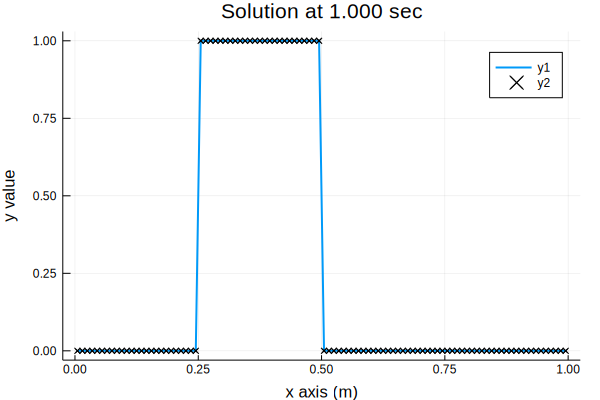

In [16]:
plotter = SolutionPlotter()

PLOTSOLUTION(plotter, mycase, mycells, time)

In [ ]:
ANIMATESOLUTION(plotter, mycase)
println("animate complete!")

In [1]:
using Plots
anim = Animation()
p = plot([sin,cos], 0, π, size=(300,300))
scatter!([0], [sin,cos])
for i in 0:0.1:π
    p[3] = [i], [sin(i)]
    p[4] = [i], [cos(i)]
    frame(anim)
end
gif(anim)

[image2 @ 0116b810]Could not find codec parameters (Video: 0x0000)
C:\Users\BENLIN~1\AppData\Local\Temp\jl_7822.tmp/%06d.png: could not find codec parameters


ErrorException: failed process: Process(`ffmpeg -v 0 -i 'C:\Users\BENLIN~1\AppData\Local\Temp\jl_7822.tmp/%06d.png' -vf palettegen=stats_mode=diff -y 'C:\Users\BENLIN~1\AppData\Local\Temp\jl_7822.tmp/palette.bmp'`, ProcessExited(1)) [1]